In [1]:
from google.colab import files
uploaded = files.upload()

Saving loan_data.csv to loan_data.csv


Dataset Shape: (268114, 13)

Columns: ['id', 'annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade', 'loan_paid_back']

Missing Values:
 id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

First few rows:
    id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0   0       29367.99                 0.084           736      2528.42   
1   1       22108.02                 0.166           636      4593.10   
2   2       49566.20                 0.097           694     17005.15   
3   3       46858.25                 0.065           533      4682.

<Figure size 800x600 with 0 Axes>

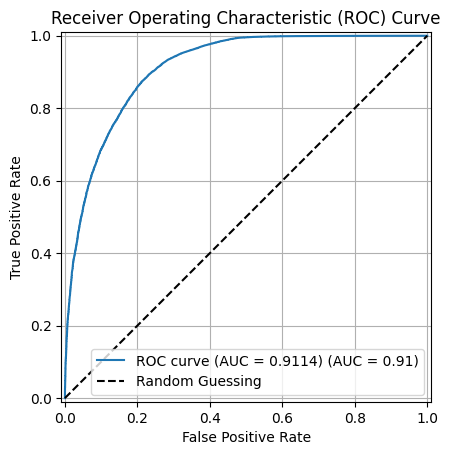


AUC by Education Level:
          Group       AUC  Count
3        Other  0.923351   2336
0   Bachelor's  0.912271  25263
1  High School  0.910458  16701
2     Master's  0.907424   8341
4          PhD  0.905822    982

AUC by Loan Purpose (Sorted):
                 Group       AUC  Count
3           Education  0.922053   3202
7            Vacation  0.918813    760
5             Medical  0.917751   2088
4                Home  0.915303   4027
6               Other  0.913596   5785
0            Business  0.911145   3091
2  Debt consolidation  0.910476  29317
1                 Car  0.900855   5353

Top 3 Loan Purposes:
        Group       AUC  Count
3  Education  0.922053   3202
7   Vacation  0.918813    760
5    Medical  0.917751   2088

Bottom 3 Loan Purposes:
                 Group       AUC  Count
0            Business  0.911145   3091
2  Debt consolidation  0.910476  29317
1                 Car  0.900855   5353


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, RocCurveDisplay

class LoanDefaultPredictor:

    RANDOM_STATE = 42
    TEST_SIZE = 0.2
    N_JOBS = -1
    RF_ESTIMATORS = 100
    RF_MAX_DEPTH = 15

    def __init__(self, filepath: str):
        self.filepath = filepath
        self.df = None
        self.model = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.y_pred_prob = None

        self.numeric_features = [
            'annual_income', 'debt_to_income_ratio', 'credit_score',
            'loan_amount', 'interest_rate'
        ]
        self.categorical_features = [
            'gender', 'marital_status', 'education_level',
            'employment_status', 'loan_purpose', 'grade_subgrade'
        ]

    def load_and_inspect_data(self):
        """Loads data and prints exploratory details."""
        self.df = pd.read_csv(self.filepath)

        print("Dataset Shape:", self.df.shape)
        print("\nColumns:", self.df.columns.tolist())
        print("\nMissing Values:\n", self.df.isnull().sum())
        print("\nFirst few rows:\n", self.df.head())
        print("\nTarget Distribution:\n", self.df['loan_paid_back'].value_counts(normalize=True))
        print("\nUnique Education Levels:", self.df['education_level'].unique())
        print("\nUnique Loan Purposes:", self.df['loan_purpose'].unique())

    def preprocess_and_split(self):
        """Splits data and builds the preprocessing pipeline."""
        X = self.df.drop(['id', 'loan_paid_back'], axis=1)
        y = self.df['loan_paid_back']

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y,
            test_size=self.TEST_SIZE,
            random_state=self.RANDOM_STATE,
            stratify=y
        )

        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ])

        preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, self.numeric_features),
            ('cat', categorical_transformer, self.categorical_features)
        ])

        self.model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                n_estimators=self.RF_ESTIMATORS,
                max_depth=self.RF_MAX_DEPTH,
                random_state=self.RANDOM_STATE,
                n_jobs=self.N_JOBS
            ))
        ])

    def train(self):
        """Fits the model to the training data."""
        print("Training Model...")
        self.model.fit(self.X_train, self.y_train)
        print("Model Trained.")

    def evaluate_performance(self):
        """Predicts probabilities and generates ROC plots."""
        print("Predicting on Test Set...")
        self.y_pred_prob = self.model.predict_proba(self.X_test)[:, 1]

        overall_auc = roc_auc_score(self.y_test, self.y_pred_prob)
        print(f"Overall Test AUC: {overall_auc:.4f}")

        plt.figure(figsize=(8, 6))
        RocCurveDisplay.from_predictions(
            self.y_test,
            self.y_pred_prob,
            name=f'ROC curve (AUC = {overall_auc:.4f})'
        )
        plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    def _calculate_group_auc(self, df: pd.DataFrame, group_col: str) -> pd.DataFrame:
        """Helper function to calculate AUC for specific subgroups."""
        results = []
        for group, sub_df in df.groupby(group_col):
            if len(sub_df['true_label'].unique()) > 1:
                auc = roc_auc_score(sub_df['true_label'], sub_df['pred_prob'])
                results.append({'Group': group, 'AUC': auc, 'Count': len(sub_df)})
            else:
                results.append({'Group': group, 'AUC': np.nan, 'Count': len(sub_df)})
        return pd.DataFrame(results).sort_values('AUC', ascending=False)

    def run_subgroup_analysis(self):
        """Performs analysis by Education and Loan Purpose."""

        analysis_df = self.X_test.copy()
        analysis_df['true_label'] = self.y_test
        analysis_df['pred_prob'] = self.y_pred_prob


        edu_results = self._calculate_group_auc(analysis_df, 'education_level')
        print("\nAUC by Education Level:\n", edu_results)


        purpose_results = self._calculate_group_auc(analysis_df, 'loan_purpose')
        print("\nAUC by Loan Purpose (Sorted):\n", purpose_results)
        print("\nTop 3 Loan Purposes:\n", purpose_results.head(3))
        print("\nBottom 3 Loan Purposes:\n", purpose_results.tail(3))


if __name__ == "__main__":

    predictor = LoanDefaultPredictor('loan_data.csv')

    predictor.load_and_inspect_data()
    predictor.preprocess_and_split()
    predictor.train()
    predictor.evaluate_performance()
    predictor.run_subgroup_analysis()